# Smoothing techniques

Smoothing is a statistical method we can use to create an approximation function to remove irregularities in data and attempt to capture significant patterns.

It utilizes weighted averages of a previous timestamp to predict a new value. **It's used for short-term forecasts; efficient when time-series moves slowly over time; it's done either additively or multiplicatively**.

### Simple Exponential Smoothing (SES)

- used for univariate data with **no clear trend or seasonal patterns**
- involves **alpha** parameter for smoothing

**Idea**: employ weighted moving average including expontially decreasing weights which gives higher weights to the most recent observation.

**Example**: a time series has:
- level ($L_t$)
- no trends
- no seasonality
- noise (somewhat constant)

$SES$ is the forecast estimate level at a most recent point in time:
$$F_{t+k}=L_t$$
Estimate and update the level ($L_t$): $$L_t=\alpha Y_t + (1 - \alpha) * L_{t-1}$$

$\alpha$ is within [0, 1]


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels.tsa.api import SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

sns.set()
plt.rcParams['figure.figsize'] = (20, 5)

In [27]:
data = pd.read_csv('../data/edge_techniques/fb.csv', parse_dates=['Date'])
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
1,2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2,2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [29]:
X = data['Close']
test = X.iloc[-30:]
train = X.iloc[:-30]

## Metrics for forecasting

- MAPE (mean absolute percentage error): a statistical measure of how accurate the forecast is. Closer to 0 = better
- RMSE

In [30]:
def timeseries_eval_metrics(true, pred):
    def mape(true, pred):
        true, pred = np.array(true), np.array(pred)
        return np.mean((true - pred) / true) * 100

    print('Evaluation metric results:')
    print(f'MSE: {metrics.mean_squared_error(true, pred)}')
    print(f'MAE: {metrics.mean_absolute_error(true, pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(true, pred))}')
    print(f'MAPE: {mape(true, pred)}')
    print(f'R2: {metrics.r2_score(true, pred)}', end='\n\n')


results = []
temp_df = pd.DataFrame()

for i in np.arange(0, 1.1, 0.1):
    print(f'Fitting smoothing level {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    pred = fit_v.forecast(30)
    timeseries_eval_metrics(test, pred)

    rmse = np.sqrt(metrics.mean_squared_error(test, pred))
    df3  = {'alpha': i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)

temp_df.sort_values(by=['RMSE'])

Fitting smoothing level 0.0
Evaluation metric results:
MSE: 3060.522993707544
MAE: 55.15632513090639
RMSE: 55.321993761139375
MAPE: 28.209613098240975
R2: -166.2161839365322

Fitting smoothing level 0.1
Evaluation metric results:
MSE: 130.19890782430633
MAE: 10.578096050945016
RMSE: 11.41047360210374
MAPE: 5.371184257014935
R2: -6.113609198116427

Fitting smoothing level 0.2
Evaluation metric results:
MSE: 108.84519758407878
MAE: 9.515377334756147
RMSE: 10.432890183648958
MAPE: 4.826729569629682
R2: -4.946917770998036

Fitting smoothing level 0.30000000000000004
Evaluation metric results:
MSE: 101.81858360183527
MAE: 9.138697491467122
RMSE: 10.090519491177611
MAPE: 4.633748018445818
R2: -4.563008361226708

Fitting smoothing level 0.4
Evaluation metric results:
MSE: 101.76016636355348
MAE: 9.135500785521595
RMSE: 10.087624416261416
MAPE: 4.632110274130487
R2: -4.55981664932594

Fitting smoothing level 0.5
Evaluation metric results:
MSE: 102.74142204977626
MAE: 9.189049476876729
RMSE: 10

,alpha,RMSE
10,1.0,9.878157
9,0.9,9.926882
8,0.8,10.008074
4,0.4,10.087624
7,0.7,10.088978
3,0.3,10.090519
5,0.5,10.136144
6,0.6,10.139199
2,0.2,10.432890
1,0.1,11.410474


In [31]:
fit_ses = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=1, optimized=False)
pred    = fit_ses.forecast(30)
timeseries_eval_metrics(test, pred)

Evaluation metric results:
MSE: 97.57797868071496
MAE: 8.90366143333332
RMSE: 9.878156643864024
MAPE: 4.513333762437967
R2: -4.331316662144517



#### SimpleExpSmoothing hyper-params tuning

- optimized=True => estimates the model parameters by maximizing the log likelihood
- use_brute=True => searches for good starting values using brute-force (grid) optimizer

In [32]:
ses = SimpleExpSmoothing(np.asarray(train)).fit(optimized=True, use_brute=True)
print(ses.summary())
ses_pred = ses.forecast(30)
timeseries_eval_metrics(test, ses_pred)

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                 1229
Model:             SimpleExpSmoothing   SSE                           8965.774
Optimized:                       True   AIC                           2446.285
Trend:                           None   BIC                           2456.513
Seasonal:                        None   AICC                          2446.318
Seasonal Periods:                None   Date:                 Mon, 16 May 2022
Box-Cox:                        False   Time:                         17:07:13
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9808445                alpha                 True
initial_level              76.525895                

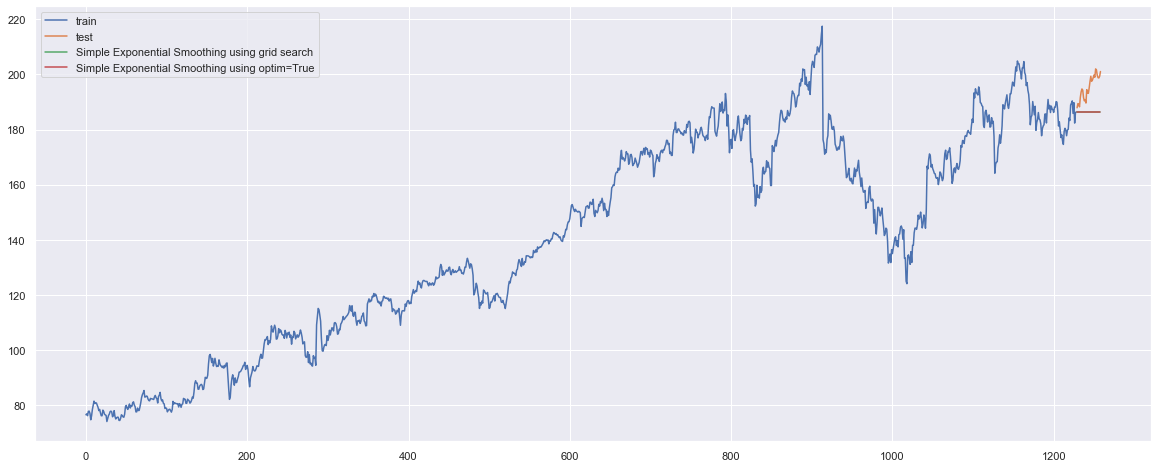

In [37]:
ses_preds = pd.DataFrame(pred, columns=['Close_grid_search'])
ses_preds['new_index'] = range(1229, 1259)
ses_preds.set_index('new_index', inplace=True)

auto_preds = pd.DataFrame(ses_pred, columns=['Close_auto_search'])
auto_preds['new_index'] = range(1229, 1259)
auto_preds.set_index('new_index', inplace=True)

plt.figure(figsize=(20, 8))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(ses_preds, label='Simple Exponential Smoothing using grid search')
plt.plot(auto_preds, label='Simple Exponential Smoothing using optim=True')
plt.legend()
plt.show()